### How to use the Hybrid Demucs model (Perform music separation)

In [1]:
# import module
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

try:
    from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
    from mir_eval import separation
except ModuleNotFoundError:
    pass

In [2]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
sample_rate = bundle.sample_rate

print(f"Sample rate: {sample_rate}") # 44.1kHz

Sample rate: 44100


### Configure the application function
It is important to protect a large and memory-consuming model

In [3]:
from torchaudio.transforms import Fade

def separate_sources(
        model,
        mix,
        segment=10.,
        overlap=0.1,
        device=None
):
    
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)
    
    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap)) # 44100 * 10 * 1.1 (default)
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate # 44100 * 0.1 (default)
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape='linear')

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)


    while start < length - overlap_frames:
        chunk = mix[:, :, start:end] # 0:485100 (default)
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final


def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    fig, ax = plt.subplots(1, 1)
    img = ax.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
    fig.suptitle(title)
    plt.colorbar(img, ax=ax)
    plt.show()

In [4]:
# Running Model
SAMPLE_SONG = download_asset("tutorial-assets/hdemucs_mix.wav")
waveform, sample_rate = torchaudio.load(SAMPLE_SONG) # Download and loading sample song
waveform = waveform.to(device)
mixture = waveform

segment: int = 10
overlap = 0.1

print("Separating track")

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std() # normalizing

sources = separate_sources(
    model,
    waveform[None],
    device=device,
    segment=segment,
    overlap=overlap
)[0]

sources = sources * ref.std() + ref.mean()

print(sources) # check

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

Separating track
tensor([[[ 1.3270e-03,  3.4187e-04, -7.8594e-04,  ..., -6.5962e-04,
          -4.3793e-04, -5.9048e-04],
         [ 1.0970e-03,  4.1520e-04, -2.6158e-04,  ..., -8.0991e-04,
          -7.2237e-04, -4.4392e-04]],

        [[ 5.5648e-03,  2.4613e-03,  1.1258e-03,  ...,  3.0369e-04,
           4.6359e-04,  5.0666e-04],
         [ 3.2583e-03,  2.3199e-03,  1.2518e-04,  ...,  2.0853e-04,
           4.8423e-04,  9.3041e-04]],

        [[ 1.4285e-03, -3.3271e-04, -2.1325e-03,  ...,  5.6967e-04,
           4.4637e-04,  2.1359e-04],
         [ 1.7368e-03,  3.0633e-03,  1.6313e-03,  ...,  9.2196e-04,
           8.3105e-04,  9.8848e-04]],

        [[ 7.7513e-04,  5.9781e-04,  5.2293e-05,  ..., -1.5194e-04,
          -1.1909e-04, -2.0859e-04],
         [ 4.6501e-04,  7.9174e-04, -4.5561e-05,  ..., -1.7722e-04,
          -1.7349e-04, -2.2499e-04]]], device='cuda:0')


In [5]:
# separate track

N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None
)

In [6]:
# Audio segmenting and Processing
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source:str):
    print("SDR score is:",
          separation.bss_eval_sources(
            original_source.detach().numpy(),
            predicted_source.detach().numpy())[0].mean()
        )
    
    plot_spectrogram(stft(predicted_source[0]), f'Spectrogram {source}')
    return Audio(predicted_source, rate=sample_rate)

In [7]:
segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate # 150 * 44100
frame_end = segment_end * sample_rate # 150 * 44100

drums_original = download_asset("tutorial-assets/hdemucs_drums_segment.wav")
bass_original = download_asset("tutorial-assets/hdemucs_bass_segment.wav")
vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")

drums_spec = audios["drums"][:, frame_start:frame_end].cpu()
drums, sample_rate = torchaudio.load(drums_original)

bass_spec = audios["bass"][:, frame_start:frame_end].cpu()
bass, sample_rate = torchaudio.load(bass_original)

vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

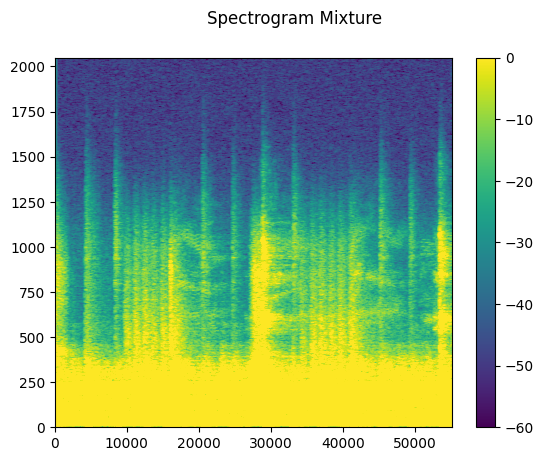

In [8]:
# Mixture clip
plot_spectrogram(stft(mix_spec)[0], "Spectrogram Mixture")
Audio(mix_spec, rate=sample_rate)

SDR score is: 5.017741382796254


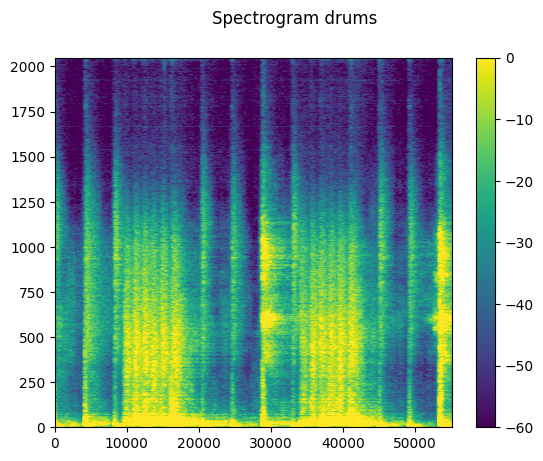

In [9]:
# Drums
output_results(drums, drums_spec, "drums")

SDR score is: 18.90896786199513


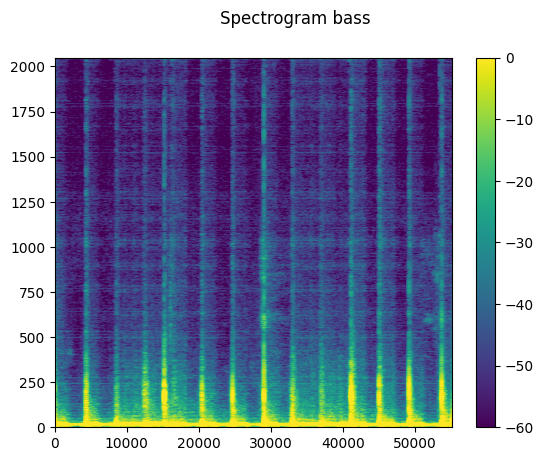

In [10]:
# Bass clip
output_results(bass, bass_spec, "bass")

SDR score is: 8.792128260193213


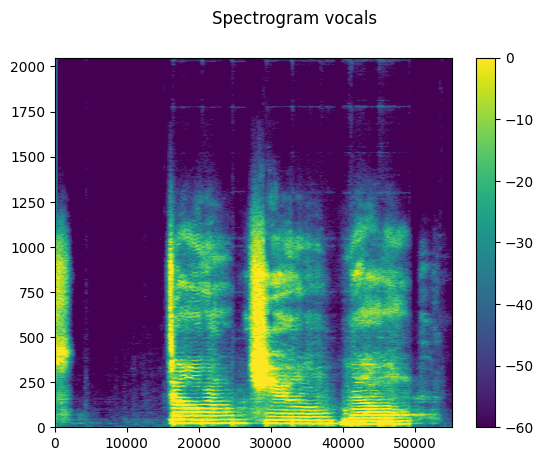

In [11]:
# Vocals Audio
output_results(vocals, vocals_spec, "vocals")

SDR score is: 8.868958284974532


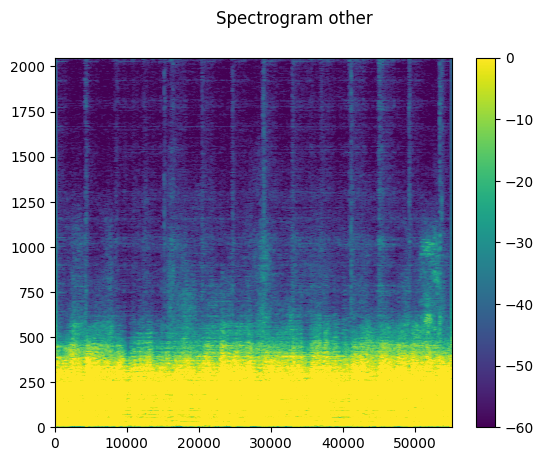

In [12]:
# Other clip
output_results(other, other_spec, "other")

In [ ]:
# Full Audio
Audio(mixture, rate=sample_rate)